# Extraction du texte 

Maintenant que l'on a repéré les décisions qui nous intéressent, on peut isoler certaines données dans ces décisions pour pouvoir faire des statistiques dessus.

L'objectif de ce notebook est d'en extraitre le plus possible, notamment :

- décision finale (oui/non)
- lieu où la décision a été prise
- quel type d'acteur (particulier / entreprise)

Pour ce faire, on va procéder comme dans le notebook précédent en cherchant des mots-clés ou des expressions régulières dans les corpis des décisions.


In [10]:
import pandas as pd # pour manipuler des tableaux de données
import matplotlib.pyplot as plt # pour dessiner des graphiques
import xml.etree.ElementTree # pour lire des fichiers XML
import os # pour manipuler des fichiers
import re # pour manipuler des expressions régulières

On ne prend que les décisions qui nous intéressent

In [11]:
# on lit le tableau csv
df = pd.read_csv('../data/intermediate_data.csv')

# décisions sur les majorations
df = df[(df.ordonnance_de_renvoi == False) & (df.majoration != 'other')]



## 1. Décision finale

Est ce que la demande a été acceptée ?

Il y a environ 600 décisions qui n'ont pas donné lieu à un rejet, cela confirme que l'étude est intéressante !



In [12]:
# function to read and parse xml file
def read_xml(file_path):
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        xml_data = file.read()
    return xml.etree.ElementTree.fromstring(xml_data)

# function to get the result of the recours with result of previous function
def get_result(xml_data):
    result = xml_data.find(".//Dossier/Solution").text
    return result


In [13]:
# function to get the result of the recours with result of previous function
df["décision"] = df["path"].apply(lambda x: get_result(read_xml(x)))

# on affiche les décisions
df["décision"].value_counts()

décision
Rejet                          1542
Satisfaction partielle          362
Satisfaction totale             103
Non-lieu                         60
Désistement                      11
ADD - Expertise / Médiation       4
Renvoi                            1
Avis article L.113-1              1
Radiation des registres           1
Name: count, dtype: int64

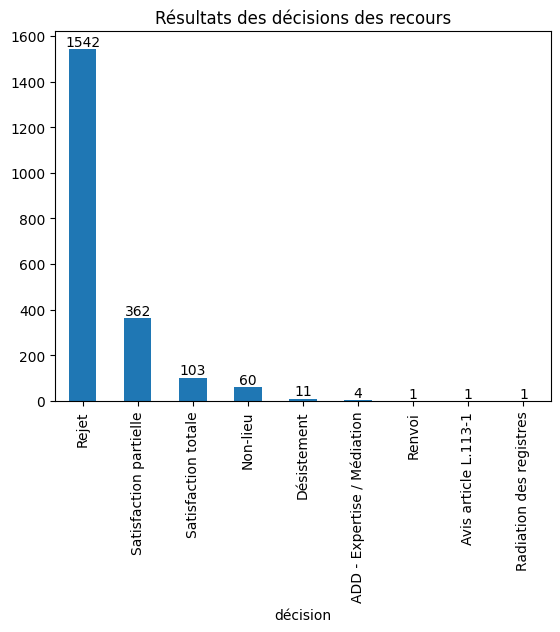

In [14]:
plot , ax = plt.subplots()

ax = df["décision"].value_counts().plot(kind='bar', title='Résultats des décisions des recours')

# display number of each bar
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height(), i.get_height(), ha='center', va='bottom')

plt.show()

# save plot 
plot.savefig('../output/resultat_des_decisions.png')


## 2. Lieu où la décision a été prise

Pour pouvoir faire des analyses géographiques

In [15]:
def get_location(xml_data):
    
    # code juridiction : TA69
    code_juridiction = xml_data.find("./Dossier/Code_Juridiction").text

    # numéro juridiction : 69
    code = ''.join(filter(str.isdigit, code_juridiction))
    
    # nom juridiction
    try :
        nom_juridiction = xml_data.find("./Dossier/Nom_Juridiction").text
    except:
        nom_juridiction = None

    return code, nom_juridiction


# read random file
random = df.sample(1)

# get result
code, nom = get_location(read_xml(random['path'].values[0]))
print("Code juridiction : ", code)
print("Nom juridiction : ", nom)



Code juridiction :  30
Nom juridiction :  Tribunal Administratif de Nîmes


Après quelques tests ça fonctionne bien.

In [16]:
df["code_juridiction"], df["nom_juridiction"] = zip(*df["path"].apply(lambda x: get_location(read_xml(x))))

#### Localisation des instances

Pour pouvoir faire une carte, on a besoin de pouvoir situer chaque tribunal administratif.

Visiblement ils sont, exception faite des départements d'outre-mer, localisé par leur code postal.

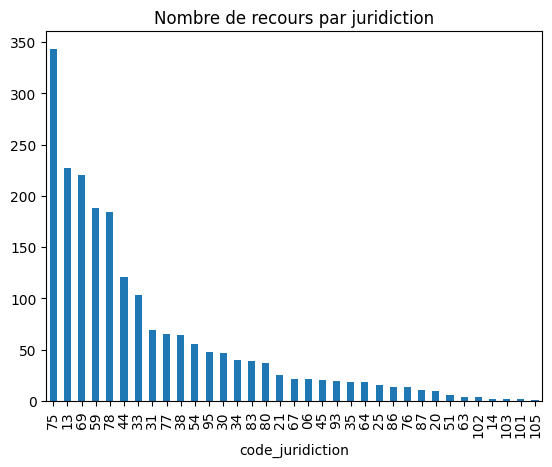

In [17]:
df.code_juridiction.value_counts().plot(kind='bar', title='Nombre de recours par juridiction').get_figure().savefig('../output/nombre_de_recours_par_juridiction.png')

## 3. Type de plaignant 

Particulier / Professionel ?

L'objectif est d'arriver à catégoriser le plaignant.

Des approches nlp ont été essayées mais ne fonctionnent pas (on a essayé de trouver par exemple le sujet de la première phrase du compte rendu, mais lesdits sujets étant anonymisés (ex: M.A. , SCIC Dupont ...) la tâche est trop compliquée).

On va donc faire une heuristique.

Notre but est de trouver des phrases où il est probable que soit l'identité du plaignant. (3.1.)

Puis de trouver ledit plaignant dans la phrase. (3.2.).

### 3.1. Trouver la phrase qui présente le plaignant

Notre but est de trouver des phrases où il est probable que soit l'identité du plaignant. (3.1.)

On a repéré deux endroits où on est à peu près sûr qu'elle se trouve.

- Au début du texte (ex: *Par une requête exprimée le ... M. A, représentée par ..... demande au tribunal :*) : cas 1

- Au milieu du texte (ex: *Considérant ce qui suit : (...) la société SAS ...*) : cas 2




#### 3.1.1. Cas 1

In [18]:

block_end = ["demande au tribunal","demande au Tribunal","demandent au tribunal","demandent au Tribunal","demandé au tribunal","demandé au Tribunal","demandant au tribunal","soutient que :","soutiennent que :"]

# trouve la première occurence du mot requête	
def get_first_sentence_case_1(xml_data):

    # on prend tous les paragraphes du texte intégral
    texte = xml_data.findall(".//Decision/Texte_Integral/p")

    # variable pour stocker le texte final
    texte_final = ""

    # tant que l'on arrive pas à un block_end, on ajoute le pargaraphe au texte final
    for p in texte:

        texte_final += p.text

        # on vérifie siun des éléments de block_end est dans le texte
        for b in block_end:
            if b in p.text:
                return texte_final
            
    
    return ""

# fonction pour tester si le texte est bien récupéré
def test_first_sentence_case_1(xml_data):
    
    texte = get_first_sentence_case_1(xml_data)

    if texte:
        return True

    return False

df["test_sentence_1"] = df["path"].apply(lambda x: test_first_sentence_case_1(read_xml(x)))
df["sentence_1"] = df["path"].apply(lambda x: get_first_sentence_case_1(read_xml(x)))
df["test_sentence_1"].value_counts()

test_sentence_1
True     2054
False      31
Name: count, dtype: int64

#### 3.1.2. Cas 2


In [19]:
# check if the doc contains the word "Considérant ce qui suit"

def test_get_sentence_case_2(xml_data):

    texte = xml_data.findall(".//Decision/Texte_Integral/p")

    for p in texte :
        if p.text != None and "Considérant ce qui suit" in p.text:
            return True

    return False

df["test_sentence_2"] = df["path"].apply(lambda x: test_get_sentence_case_2(read_xml(x)))

df["test_sentence_2"].value_counts()

test_sentence_2
True     2078
False       7
Name: count, dtype: int64

Visiblement c'est le cas, on inspecte les décisions qui ne le contiennent pas.

Il s'avère que ces cas de figure sont dûs à des coquilles (ex : "Considérant ce suit").

In [20]:
# fonction pour récupérer le texte
def get_sentence_case_2(xml_data):

    texte = xml_data.findall(".//Decision/Texte_Integral/p")

    try :
        for p in texte :
            if p.text != None and "Considérant ce qui suit" in p.text:
                
                # on renvoie la première phrase du paragraphe suivant
                next_p = texte[texte.index(p) + 1].text

                # on cherche la première phrase
                # sachant qu'elle commence par 1. 
                # donc on prend entre le premier et le troisème point
                # ex: 1. M. X a demandé au tribunal...
                return next_p.split(".")[1] + "." + next_p.split(".")[2] + "."
    
    except:
        return "error"

df["sentence_2"] = df["path"].apply(lambda x: get_sentence_case_2(read_xml(x)))


### 3.2. Trouver le type de plaignant

Une fois que l'on a les phrases d'intérêts, on cherche à trouver le nom du plaignant dans ces phrases grâce à des expressions régulières.

In [21]:

# différentes manières de désigner une personne (M. A , Mme B, M. et Mme C...)
pattern_particulier = [r"M\s[A-Z]",r"M\.\s[A-Z]", r"Mme\s[A-Z]", r"Mlle\s[A-Z]",r"M. et Mme\s[A-Z]"]

def get_particulier(texte):
    for pattern in pattern_particulier:
        if re.search(pattern, texte):
            # personne physique
            return "P.P.", re.search(pattern, texte).group()
    return None, None

# différentes manières de désigner une personne morale (SARL A, SCI B, ...)
pattern_societe = ["société","association","SAS","SA","SCIC","SCM","SCA","SNC","SARL","SELARL","SARLU","SASU","SCA","SC","Sarl","GIE","EURL","EIRL","EI","AE","auto-entrepreneur","auto entrepreneur","entreprise"]

def get_societe(texte):
    for pattern in pattern_societe:
        if re.search(pattern, texte):
            # personne morale
            return "P.M.", re.search(pattern, texte).group()
    return None , None

def categorize_personne(texte):



    if texte == "error":
        return "error", "error"
    
    elif texte == None:
        return "empty", "empty"
    
    elif get_societe(texte) != (None, None):
        return get_societe(texte)

    elif get_particulier(texte) != (None, None):
        return get_particulier(texte)

    else:
        return "not found", "not found"


### 3.3. Résultats

Maintenant que l'on a les phrases et la manière de les analyser, on peut laisser la magie intervenir.

Si les deux tests (sur le cas 1 et le cas 2) donnent le même résultat, on se dit qu'il doit être bon.

En cas de doute, l'expérience montre que c'est le cas 2 qui a raison.

In [22]:
df["personne_1"],df["match_1"] = zip(*df["sentence_1"].apply(lambda x: categorize_personne(x)))

df["personne_2"],df["match_2"] = zip(*df["sentence_2"].apply(lambda x: categorize_personne(x)))



In [23]:

# fonction qui synthétise les deux tests précédents
def get_personne_synthetic(case_1, case_2):
    if case_1 == case_2:
        return case_1
    elif case_2 in ["empty","error","not found"]:
        return case_1
    else:
        return case_2
    
# on applique la fonction à la colonne sentence_1 et sentence_2
df["personne_synthetic"] = df.apply(lambda x: get_personne_synthetic(x["personne_1"], x["personne_2"]), axis=1)

# on affiche le nombre de conflits
df["personne_synthetic"].value_counts()

personne_synthetic
P.M.         1596
P.P.          487
not found       2
Name: count, dtype: int64

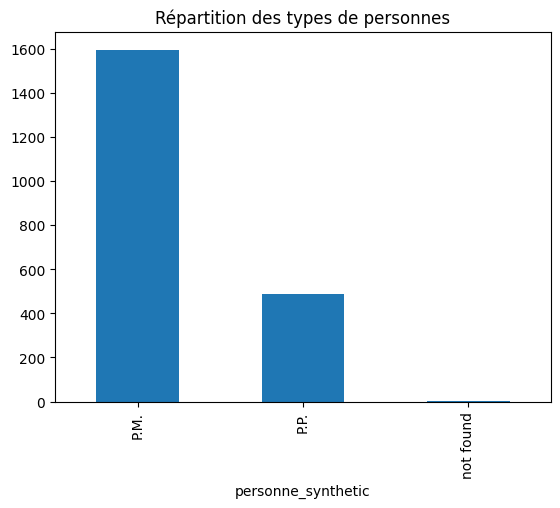

In [24]:
# plot
df["personne_synthetic"].value_counts().plot(kind='bar', title='Répartition des types de personnes').get_figure().savefig('../output/repartition_des_types_de_personnes.png')

# on sauvegarde le dataframe
df.to_csv('../data/intermediate_data.csv', index=False)